# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 04**: Data Unions & Joins Pipeline

**Date**: September 23rd 2025

**Student Name**: Jaime Enrique Galindo Villegas

**Professor**: Pablo Camarillo Ramirez

In [54]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on SparkSQL") \
    .master("spark://9d7a5c0179a1:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [55]:
!ls /opt/spark/work-dir/data/car_service/

agencies  brands  cars	customers  output  rentals


In [56]:
# Build schema
# Import your module
from jaime_galindo.spark_utils import SparkUtils
from pyspark.sql.functions import get_json_object


In [57]:

# Generar esquema
schema_agencies = SparkUtils.generate_schema([("agency_id", "int"), ("agency_info", "string")])

# Generar df
df_agencies = spark.read.schema(schema_agencies).option("header", True).csv("/opt/spark/work-dir/data/car_service/agencies")

# Crear las nuevas columnas
df_agencies = df_agencies.withColumn("agency_name", get_json_object(df_agencies.agency_info, "$.agency_name")).drop("agency_info")


In [58]:
# Generar esquema
schema_brands = SparkUtils.generate_schema([("brand_id", "int"), ("brand_info", "string")])

# Generar df
df_brands = spark.read.schema(schema_brands).option("header", True).csv("/opt/spark/work-dir/data/car_service/brands")

# Crear las nuevas columnas
df_brands = df_brands.withColumn("brand_name", get_json_object(df_brands.brand_info, "$.brand_name")).drop("brand_info")


In [59]:
# Generar esquema
schema_cars = SparkUtils.generate_schema([("car_id", "int"), ("car_info", "string")])

# Generar df
df_cars = spark.read.schema(schema_cars).option("header", True).csv("/opt/spark/work-dir/data/car_service/cars")

# Crear las nuevas columnas
df_cars = df_cars.withColumn("car_name", get_json_object(df_cars.car_info, "$.car_name")).drop("car_info")


In [60]:
# Generar esquema
schema_customers = SparkUtils.generate_schema([("customer_id", "int"), ("customer_info", "string")])

# Generar df
df_customers = spark.read.schema(schema_customers).option("header", True).csv("/opt/spark/work-dir/data/car_service/customers/")

# Crear las nuevas columnas
df_customers = df_customers.withColumn("customer_name", get_json_object(df_customers.customer_info, "$.customer_name")).drop("customer_info")


In [61]:
# Generar esquema
schema_rentals = SparkUtils.generate_schema([("rental_id", "int"), ("rental_info", "string")])

# Generar df
df_rentals = spark.read.schema(schema_rentals).option("header", True).csv("/opt/spark/work-dir/data/car_service/rentals")

# Crear las nuevas columnas
df_rentals = df_rentals.withColumn("car_id", get_json_object(df_rentals.rental_info, "$.car_id"))
df_rentals = df_rentals.withColumn("customer_id", get_json_object(df_rentals.rental_info, "$.customer_id"))
df_rentals = df_rentals.withColumn("agency_id", get_json_object(df_rentals.rental_info, "$.agency_id"))
df_rentals = df_rentals.drop("rental_info")


In [62]:
# Joins
df_rentals = df_rentals.join(df_cars, on="car_id", how="left")
df_rentals = df_rentals.join(df_customers, on="customer_id", how="left")
df_rentals = df_rentals.join(df_agencies, on="agency_id", how="left")

# Eliminar columnas extra
df_rentals = df_rentals.drop("agency_id", "customer_id", "car_id")

df_rentals.show(truncate=False)

+---------+-----------------------------------+---------------+-------------+
|rental_id|car_name                           |customer_name  |agency_name  |
+---------+-----------------------------------+---------------+-------------+
|11891    |Wallace-Carlson Model 9            |Margaret Jones |NYC Rentals  |
|11892    |Grimes-Green Model 8               |Albert Williams|LA Car Rental|
|11893    |Stewart-Allen Model 5              |Caleb Fleming  |SF Cars      |
|11894    |Campos PLC Model 4                 |Andrew Butler  |NYC Rentals  |
|11895    |Wagner LLC Model 1                 |Kristin Potts  |SF Cars      |
|11896    |Jones, Jefferson and Rivera Model 7|Jeremy Parks   |LA Car Rental|
|11897    |Lopez and Sons Model 9             |Terry Wells    |Zapopan Auto |
|11898    |Salazar Ltd Model 8                |Marc Williams  |SF Cars      |
|11899    |Villanueva PLC Model 7             |Danny Williams |LA Car Rental|
|11900    |Faulkner-Howard Model 5            |Eric Owens PhD |S

In [63]:
!pwd

/opt/spark/work-dir


In [64]:
!du -sh data/car_service/rentals/

1.1M	data/car_service/rentals/


In [65]:
base_path = "/opt/spark/work-dir/data/"

In [66]:
df_rentals.write \
				.mode("overwrite") \
            .parquet(base_path + "car_service/output/parquet")


In [67]:
!ls data/car_service/output/parquet/

part-00000-bef00ae1-056d-4e11-a4f9-7eaf8c278042-c000.snappy.parquet  _SUCCESS
part-00001-bef00ae1-056d-4e11-a4f9-7eaf8c278042-c000.snappy.parquet


In [68]:
!du -sh data/car_service/output/parquet/

124K	data/car_service/output/parquet/


In [69]:
df_rentals.write \
				.partitionBy("agency_name") \
				.mode("overwrite") \
            .parquet(base_path + "car_service/output/parquet")


In [70]:
!ls data/car_service/output/parquet/


'agency_name=LA Car Rental'  'agency_name=SF Cars'	  _SUCCESS
'agency_name=NYC Rentals'    'agency_name=Zapopan Auto'


In [71]:
!du -sh data/car_service/output/parquet/

144K	data/car_service/output/parquet/


## CSV files

In [72]:
df_rentals.write \
				.partitionBy("agency_name") \
				.mode("overwrite") \
            .option("header", True) \
            .csv(base_path + "/car_service/output/csv")

In [73]:
!ls data/car_service/output/csv/

'agency_name=LA Car Rental'  'agency_name=SF Cars'	  _SUCCESS
'agency_name=NYC Rentals'    'agency_name=Zapopan Auto'


In [74]:
!du -sh data/car_service/output/csv/

856K	data/car_service/output/csv/


In [75]:
sc.stop()


#### No me funcionó en Power BI del navegador así que lo hice en el escritorio
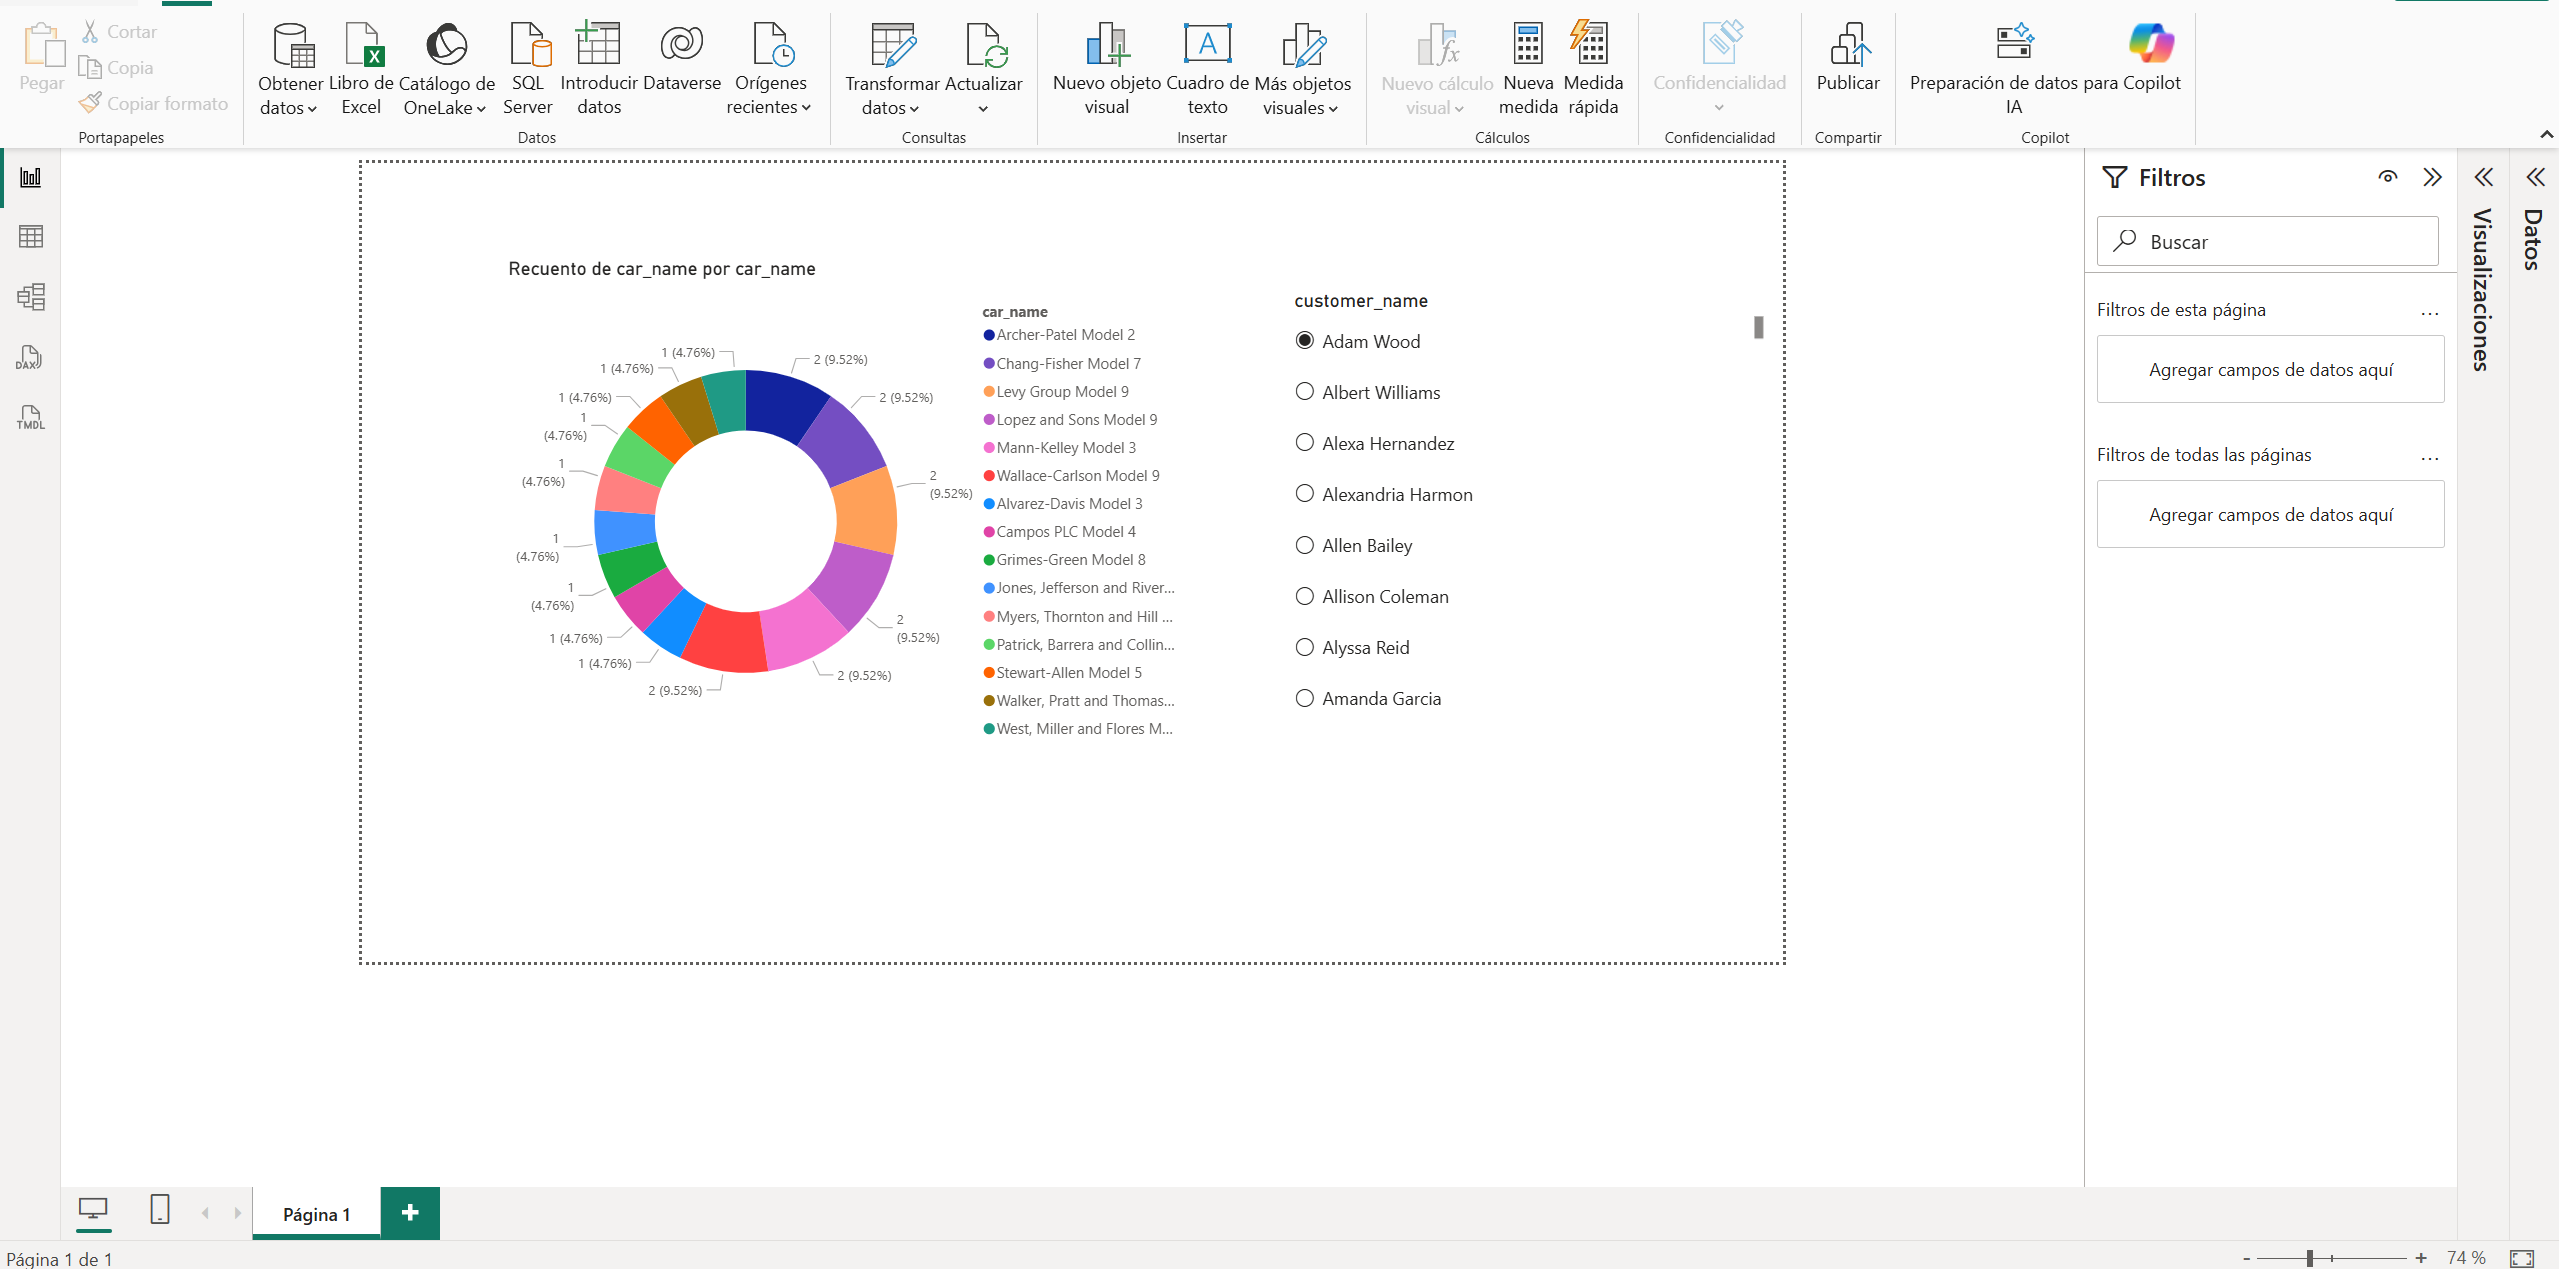
